In [1]:
pip install astropy scipy matplotlib numpy h5py tqdm numba pint-pulsar emcee corner statsmodels pyfftw tbb

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pytest pytest-astropy jinja2 docutils sphinx-astropy nbsphinx pandoc ipython jupyter notebook towncrier tox black

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install stingray PyROA emcee tabulate corner astropy

Note: you may need to restart the kernel to use updated packages.


In [4]:
%cd /home/jovyan/AS4013/PYCCF

/home/jovyan/AS4013/PYCCF


In [5]:
import shutil

# Replace '/path/to/work_directory' with your actual work directory
work_directory = '/home/jovyan/AS4013'

# Copy xcorspc.so and PYCCF.py to the work directory
shutil.copy('xcorspc.pyx', work_directory)
shutil.copy('PYCCF.py', work_directory)

'/home/jovyan/AS4013/PYCCF.py'

In [6]:
import numpy as np
from stingray import Lightcurve, Crossspectrum, AveragedCrossspectrum
import sys
import argparse
import PYCCF as myccf
import random
from scipy import stats 
import os
import PyROA
import matplotlib.pyplot as plt
import psi
from scipy.integrate import simps

import importlib
importlib.reload(psi)


/opt/conda/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


<module 'psi' from '/home/jovyan/AS4013/psi.py'>

In [7]:
#import AGN light curve
directory_path = '/home/jovyan/AS4013'
file_name = 'lc30mins.dat'
file_path = os.path.join(directory_path, file_name)

column_index1 = 0  
column_index2 = 1

with open(file_path, 'r') as file:
    # Read all lines
    lines = file.readlines()
    data_lines = lines[1:]
    
   # Extract the desired columns from each line and convert to float
    column1_data = [float(line.split()[column_index1]) for line in data_lines]
    column2_data = [float(line.split()[column_index2]) for line in data_lines]

time = np.array(column1_data)/(24*3600)
flux = np.array(column2_data)

## Generate Light curves and Response functions

In [8]:
#########################################
##Set Interpolation settings, user-specified
#########################################
lag_range = [-100, 100]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 0.2 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 10  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.
#########################################
##Set freq-lag settings, user-specified
#########################################
cs_binning = 100 #averaged cross spectrum binning 
error_in_flux = 0.01 #define percentage error in flux 
SN = 100 #sound to noise ratio 
samplng_rate = 1 #how many samples are taken per day 
sampling_loss = 0.2 # the amount of data lost due to sampling issues
final_length = 350 #length of final array in days 
dt = 1800 #each interval in seconds 
S = 1.0 #SD of BLR function
M = np.log(13.9) # Mean of BLR function
BLR_fraction = 0.5 # BLR fraction

exposure = len(time) #length of full array 
seconds_day = 86400
original_length = exposure/(seconds_day/dt)

times = (np.linspace(-exposure, exposure+1, num = exposure*2)*dt)/(24*3600) # converted to days

#define disk function
def disk(times,wavelength,A1):
    bhmass = 10**7.7       # Msol
    mdot = 0.5         # Msol/yr
    inc = 45           # inclination, degrees
    combi_psi = psi.pytfb_sub(times,1e8,mdot,wavelength,inc,norm=1)
    combi_psi[np.isnan(combi_psi)]=0
    # normalise 
    normi = simps(combi_psi,x=times)
    return A1*(combi_psi/normi)

# Define BLR function
def BLR(times,A2):

    BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
    BLR_array[np.isnan(BLR_array)]=0
    return  BLR_array

BLR_array_1 = BLR(times, BLR_fraction)
combi_psi_1 = disk(times, 4770, (1 - BLR_fraction))

signal_BLR_Disk = BLR_array_1 + combi_psi_1

### Perform convolution
signal4_BLR = np.convolve(flux, signal_BLR_Disk, mode='full')
signal_BLR = np.convolve(flux, BLR(times, 1), mode='full')
signal_DISK = np.convolve(flux, disk(times, 4770, 1), mode='full')

start_index = int((len(signal4_BLR) - len(flux)) / 2)
end_index = start_index + len(flux)
signal4_BLR = signal4_BLR[start_index:end_index]

start_index1 = int((len(signal_BLR) - len(flux)) / 2)
end_index1 = start_index1 + len(flux)
signal_BLR = signal_BLR[start_index1:end_index1]

start_index2 = int((len(signal_DISK) - len(flux)) / 2)
end_index2 = start_index2 + len(flux)
signal_DISK = signal_DISK[start_index2:end_index2]

#take a smaple each day 
interval = (original_length-final_length)/2
start = int(seconds_day/dt*interval)
end = int(seconds_day/dt*(original_length-interval))

signal_combined = signal4_BLR[start:end]
signal_BLR = signal_BLR[start:end]
signal_DISK = signal_DISK[start:end]
flux = flux[start:end]
time = time[start:end]

lc_BLR = Lightcurve(time,signal_BLR )
lc_full = Lightcurve(time,signal_combined )
lc_disk = Lightcurve(time,signal_DISK )
lc = Lightcurve(time,flux)

/tmp/ipykernel_1052/2370750978.py:43: RuntimeWarning: invalid value encountered in sqrt
  BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
/tmp/ipykernel_1052/2370750978.py:43: RuntimeWarning: invalid value encountered in log
  BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))


In [9]:
new_times = []
new_BLR = []
new_disk = []
new_full = []
new_flux = []


#sample randomly
for i in range(final_length):
    
    random_number = random.randint(0, seconds_day/dt)
    index = int(i*seconds_day/dt) + random_number
    
    new_times.append(time[index])
    new_flux.append(flux[index])
    new_BLR.append(signal_BLR[index])
    new_disk.append(signal_DISK[index])
    new_full.append(signal_combined[index])


lost_data = int(len(new_flux)*sampling_loss)  

#remove lost data
for i in range(lost_data):
    
    random_number = random.randint(0,len(new_times)-1)
    new_flux.pop(random_number)
    new_times.pop(random_number)
    new_BLR.pop(random_number)
    new_disk.pop(random_number)
    new_full.pop(random_number)

#create lightcurves
lc_BLR = Lightcurve(new_times,new_BLR )
lc = Lightcurve(new_times,new_flux)
lc_full = Lightcurve(new_times,new_full )
lc_disk = Lightcurve(new_times,new_disk )

/opt/conda/lib/python3.11/site-packages/stingray/utils.py:406: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.Only use with LombScargleCrossspectrum, LombScarglePowerspectrum and QPO using GPResult
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [10]:
#getting mean 
mean_lc_full = np.mean(lc_full.counts)
mean_lc_disk = np.mean(lc_disk.counts)
mean_lc_BLR = np.mean(lc_BLR.counts)
mean_lc = np.mean(lc.counts)

#getting standard deviation
sd_lc_full = np.std(lc_full.counts)
sd_lc_disk = np.std(lc_disk.counts)
sd_lc_BLR = np.std(lc_BLR.counts)
sd_lc = np.std(lc.counts)

#normalising
lc_full_N = (lc_full.counts-mean_lc_full)/sd_lc_full
lc_disk_N = (lc_disk.counts-mean_lc_disk)/sd_lc_disk
lc_BLR_N = (lc_BLR.counts-mean_lc_BLR)/sd_lc_BLR
lc_N = (lc.counts-mean_lc)/sd_lc

# and adding noise
lc_full_N = np.random.normal(lc_full_N,abs(lc_full_N/SN))
lc_disk_N = np.random.normal(lc_disk_N,abs(lc_disk_N/SN))
lc_BLR_N = np.random.normal(lc_BLR_N,abs(lc_BLR_N/SN))
lc_N = np.random.normal(lc_N,abs(lc_N/SN))

#create normalised lightcurves
lc_full_N = Lightcurve(lc_BLR.time,lc_full_N)
lc_disk_N = Lightcurve(lc_disk.time,lc_disk_N)
lc_BLR_N = Lightcurve(lc_BLR.time,lc_BLR_N)
lc_N = Lightcurve(lc.time,lc_N)

#create errors in flux 
lc_N.counts_err = abs(lc_N.counts*error_in_flux)
lc_BLR_N.counts_err = abs(lc_BLR_N.counts*error_in_flux)
lc_disk_N.counts_err = abs(lc_disk_N.counts*error_in_flux)
lc_full_N.counts_err = abs(lc_full_N.counts*error_in_flux)



In [11]:
#perform interpolation using PYROA
(lc_P_times,lc_P_counts,lc_P_err) = PyROA.RunningOptimalAverage(lc_N.time,lc_N.counts,lc_N.counts_err,1)
(lc_BLR_P_times,lc_BLR_P_counts,lc_BLR_P_err) = PyROA.RunningOptimalAverage(lc_BLR_N.time,lc_BLR_N.counts,lc_BLR_N.counts_err,1)
(lc_full_P_times,lc_full_P_counts,lc_full_P_err) = PyROA.RunningOptimalAverage(lc_full_N.time,lc_full_N.counts,lc_full_N.counts_err,1)
(lc_disk_P_times,lc_disk_P_counts,lc_disk_P_err) = PyROA.RunningOptimalAverage(lc_disk_N.time,lc_disk_N.counts,lc_disk_N.counts_err,1)

#create the interpolated Lightcurves
lcp = Lightcurve(lc_P_times,lc_P_counts,err = lc_P_err)
lcBLRp = Lightcurve(lc_BLR_P_times,lc_BLR_P_counts,err = lc_BLR_P_err)
lcfullp = Lightcurve(lc_full_P_times,lc_full_P_counts,err = lc_full_P_err)
lcdiskp = Lightcurve(lc_disk_P_times,lc_disk_P_counts,err = lc_disk_P_err)

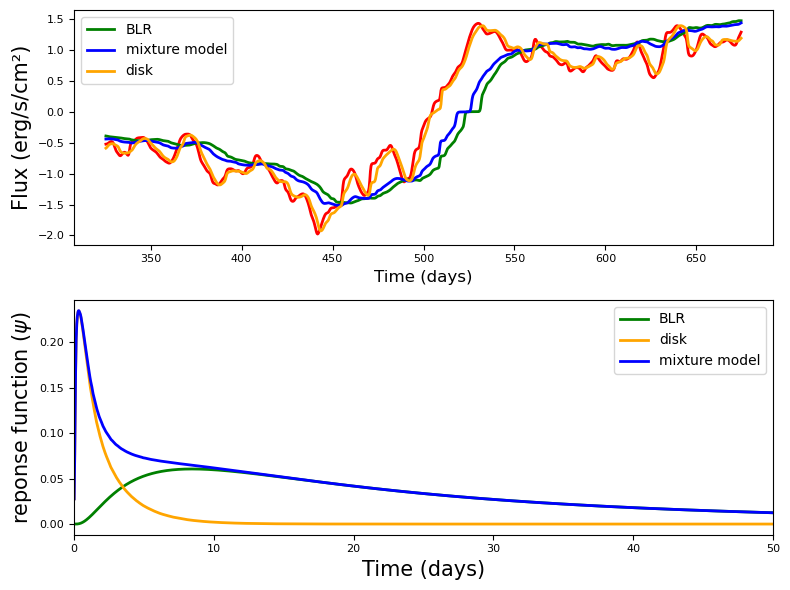

In [12]:
# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

axes[0].plot(lcp.time, lcp.counts, lw=2, color='red')
axes[0].plot( lcBLRp.time,lcBLRp.counts, lw=2, color='green',label = 'BLR')
axes[0].plot( lcfullp.time,lcfullp.counts, lw=2, color='blue',label = 'mixture model')
axes[0].plot( lcdiskp.time,lcdiskp.counts, lw=2, color='orange',label = 'disk')
axes[0].set_xlabel("Time (days)",fontsize=12 )
axes[0].set_ylabel("Flux (erg/s/cm²)",fontsize=15)
axes[0].tick_params(axis='x', labelsize=8)
axes[0].tick_params(axis='y', labelsize=8)
axes[0].legend()

axes[1].plot(times, BLR_array_1, lw=2, color='green',label = 'BLR')
axes[1].plot(times, combi_psi_1, lw=2, color='orange',label = 'disk')
axes[1].plot(times, signal_BLR_Disk, lw=2, color='blue',label = 'mixture model')
axes[1].set_xlabel("Time (days)",fontsize=15 )
axes[1].set_ylabel(r"reponse function ($\psi$)",fontsize=15)
axes[1].set_xlim(0,50)
axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)
axes[1].legend()



# Adjust layout to prevent overlap
plt.tight_layout()

# Show or save the figure
plt.show()

## Detrend find cross spectrum and frequency resolved lags 

In [13]:
#detrend 

# Define a function to detrend a dataset
def detrend_data(time, counts):
    # Fit a linear model to the data
    m, b = np.polyfit(time, counts, 1)
    
    # Calculate the linear trend
    linear_trend = m * time + b
    
    # Subtract the linear trend from the original data
    detrended_counts = counts - linear_trend
    
    return detrended_counts

# Detrend lcfullp
detrended_counts_full = detrend_data(lcfullp.time, lcfullp.counts)

# Detrend lcdiskp
detrended_counts_disk = detrend_data(lcdiskp.time, lcdiskp.counts)

# Detrend lcBLRp
detrended_counts_BLR = detrend_data(lcBLRp.time, lcBLRp.counts)

# Detrend lcp
detrended_counts_p = detrend_data(lcp.time, lcp.counts)

In [14]:
#create the interpolated Lightcurves
lcp = Lightcurve(lc_P_times,detrended_counts_p,err = lc_P_err)
lcBLRp = Lightcurve(lc_BLR_P_times,detrended_counts_BLR,err = lc_BLR_P_err)
lcfullp = Lightcurve(lc_full_P_times,detrended_counts_full,err = lc_full_P_err)
lcdiskp = Lightcurve(lc_disk_P_times,detrended_counts_disk,err = lc_disk_P_err)

In [16]:
#average cross spectrum 
avg_cs_BLR = AveragedCrossspectrum.from_lightcurve(lcBLRp, lcp, cs_binning)
avg_cs_full = AveragedCrossspectrum.from_lightcurve(lcfullp, lcp, cs_binning)
avg_cs_disk = AveragedCrossspectrum.from_lightcurve(lcdiskp, lcp, cs_binning)

#logarithmically rebin 
log_rb_cs_BLR = avg_cs_BLR.rebin_log(f=1.2)
log_rb_cs_full = avg_cs_full.rebin_log(f=1.2)
log_rb_cs_disk = avg_cs_disk.rebin_log(f=1.2)

#define time and phase lags 
freq_lags_BLR, freq_lags_err_BLR = log_rb_cs_BLR.time_lag()
freq_lags_full, freq_lags_err_full = log_rb_cs_full.time_lag()
freq_lags_disk, freq_lags_err_disk = log_rb_cs_disk.time_lag()

3it [00:00, 1009.62it/s]
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1914: RuntimeWarning: invalid value encountered in sqrt
  n_ph = np.sqrt(n_ph1 * n_ph2)
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1125: UserWarning: n_ave is below 30. Please note that the error bars on the quantities derived from the cross spectrum are only reliable for a large number of averaged powers.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1139: RuntimeWarning: invalid value encountered in sqrt
  dRe = dIm = dG = np.sqrt(power_over_2n * (seg_power - frac))
/opt/conda/lib/python3.11/site-packages/stingray/fourier.py:1141: RuntimeWarning: invalid value encountered in sqrt
  dphi = np.sqrt(
/opt/conda/lib/python3.11/site-packages/stingray/crossspectrum.py:2912: UserWarning: Some error bars in the Averaged Crossspectrum are invalid.Defaulting to sqrt(2 / M) in Leahy norm, rescaled to the appropriate norm.
  warnings.warn(
/opt/conda/lib/python3.11

In [17]:
print(freq_lags_BLR)
print(freq_lags_full)
print(freq_lags_disk)

[ 1.26921656e+01  7.40728411e+00  2.65617710e+00 -1.26684972e-01
 -6.12362956e-02  8.05706637e-03 -1.91553379e-05]
[ 8.53947834e+00  3.49061833e+00  1.35880257e+00  1.14446900e-01
  3.83981429e-02 -1.29044591e-05  5.35373904e-04]
[8.11970623e-01 6.18351214e-01 7.52737914e-01 3.48455532e-02
 1.29381179e-02 2.34116237e-03 6.65786633e-05]


## Find mean Lag using response function

In [18]:
response_function = BLR(times,BLR_fraction)+disk(times, 4770, (1 - BLR_fraction))
BLR_array = BLR(times,1)
Disk_array = disk(times, 4770, 1)
#find mean lag 
mean_lag_full = np.sum(response_function * times) / np.sum(response_function)
mean_lag_BLR = np.sum(BLR_array * times) / np.sum(BLR_array)
mean_lag_Disk = np.sum(Disk_array * times) / np.sum(Disk_array)

/tmp/ipykernel_1052/2370750978.py:43: RuntimeWarning: invalid value encountered in sqrt
  BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))
/tmp/ipykernel_1052/2370750978.py:43: RuntimeWarning: invalid value encountered in log
  BLR_array = A2/(S*np.sqrt(2*np.pi*times))*np.exp(-(np.log(times)-M)**2/(2*(S**2)))


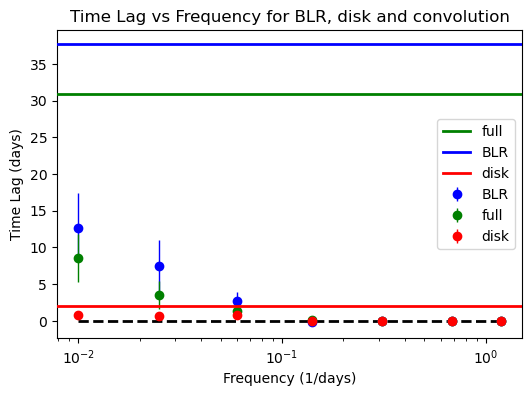

In [19]:

# Plotting
plt.figure(figsize=(6, 4))
plt.hlines(0, log_rb_cs_BLR.freq[0], log_rb_cs_BLR.freq[-1], color='black', linestyle='dashed', lw=2)
plt.errorbar(log_rb_cs_BLR.freq, freq_lags_BLR, yerr=freq_lags_err_BLR, fmt="o", label='BLR', lw=1, color='b')
plt.errorbar(log_rb_cs_full.freq, freq_lags_full, yerr=freq_lags_err_full, fmt="o", label=f'full', lw=1, color='g')
plt.errorbar(log_rb_cs_disk.freq, freq_lags_disk, yerr=freq_lags_err_disk, fmt="o", label=f'disk', lw=1, color='r')
plt.axhline(mean_lag_full,  lw=2, label=f'full', color='g', zorder=10)
plt.axhline(mean_lag_BLR,  lw=2, label=f'BLR', color='b', zorder=10)
plt.axhline(mean_lag_Disk, lw=2, label=f'disk',color='r', zorder=10)
plt.xscale('log')
plt.xlabel('Frequency (1/days)')
plt.ylabel('Time Lag (days)')
plt.title('Time Lag vs Frequency for BLR, disk and convolution')
plt.legend()

plt.show()

## Use PYCCF to find mean lag 

In [20]:
import sys
import argparse
import PYCCF as myccf

#########################################
##Set Interpolation settings, user-specified
#########################################
lag_range = [-100, 100]  #Time lag range to consider in the CCF (days). Must be small enough that there is some overlap between light curves at that shift (i.e., if the light curves span 80 days, these values must be less than 80 days)
interp = 0.2 #Interpolation time step (days). Must be less than the average cadence of the observations, but too small will introduce noise.
nsim = 300  #Number of Monte Carlo iterations for calculation of uncertainties
mcmode = 0  #Do both FR/RSS sampling (1 = RSS only, 2 = FR only) 
sigmode = 0.2  #Choose the threshold for considering a measurement "significant". sigmode = 0.2 will consider all CCFs with r_max <= 0.2 as "failed". See code for different sigmodes.


In [21]:
#peforming PYCCf

mjd2 = lcfullp.time
flux2 = lcfullp.counts
mjd3 = lcBLRp.time
flux3 = lcBLRp.counts
mjd4 = lcdiskp.time
flux4 = lcdiskp.counts
mjd1 = lcp.time
flux1 = lcp.counts 
err1 = lcp.counts_err
err2 = lcfullp.counts_err
err3 = lcBLRp.counts_err
err4 = lcdiskp.counts_err

tlag_peak_12, status_peak_12, tlag_centroid_12, status_centroid_12, ccf_pack_12, max_rval_12, status_rval_12, pval_12 = myccf.peakcent(mjd1, flux1, mjd2, flux2, lag_range[0], lag_range[1], interp)
# Compare mjd1, flux1 and mjd3, flux3
tlag_peak_13, status_peak_13, tlag_centroid_13, status_centroid_13, ccf_pack_13, max_rval_13, status_rval_13, pval_13 = myccf.peakcent(mjd1, flux1, mjd3, flux3, lag_range[0], lag_range[1], interp)
# Compare mjd1, flux1 and mjd4, flux4
tlag_peak_14, status_peak_14, tlag_centroid_14, status_centroid_14, ccf_pack_14, max_rval_14, status_rval_14, pval_14 = myccf.peakcent(mjd1, flux1, mjd4, flux4, lag_range[0], lag_range[1], interp)

# Compare mjd1, flux1 and mjd2, flux2
tlags_peak_12, tlags_centroid_12, nsuccess_peak_12, nfail_peak_12, nsuccess_centroid_12, nfail_centroid_12, max_rvals_12, nfail_rvals_12, pvals_12 = myccf.xcor_mc(mjd1, flux1, abs(err1), mjd2, flux2, abs(err2), lag_range[0], lag_range[1], interp, nsim=nsim, mcmode=mcmode, sigmode=0.2)


# Compare mjd1, flux1 and mjd3, flux3
tlags_peak_13, tlags_centroid_13, nsuccess_peak_13, nfail_peak_13, nsuccess_centroid_13, nfail_centroid_13, max_rvals_13, nfail_rvals_13, pvals_13 = myccf.xcor_mc(mjd1, flux1, abs(err1), mjd3, flux3, abs(err3), lag_range[0], lag_range[1], interp, nsim=nsim, mcmode=mcmode, sigmode=0.2)


# Compare mjd1, flux1 and mjd4, flux4
tlags_peak_14, tlags_centroid_14, nsuccess_peak_14, nfail_peak_14, nsuccess_centroid_14, nfail_centroid_14, max_rvals_14, nfail_rvals_14, pvals_14 = myccf.xcor_mc(mjd1, flux1, abs(err1), mjd4, flux4, abs(err4), lag_range[0], lag_range[1], interp, nsim=nsim, mcmode=mcmode, sigmode=0.2)


lag12 = ccf_pack_12[1]
r12 = ccf_pack_12[0]
lag13 = ccf_pack_13[1]
r13 = ccf_pack_13[0]
lag14 = ccf_pack_14[1]
r14 = ccf_pack_14[0]

perclim = 84.1344746  


Failed centroids:  0
Failed peaks:  0
Failed centroids:  0
Failed peaks:  0
Failed centroids:  0
Failed peaks:  0


In [22]:
from scipy import stats

# For pair 1 and 2
centau_12 = stats.scoreatpercentile(tlags_centroid_12, 50)
centau_uperr_12 = stats.scoreatpercentile(tlags_centroid_12, 100 - perclim) - centau_12
centau_loerr_12 = centau_12 - stats.scoreatpercentile(tlags_centroid_12, perclim)
print('Centroid for 1 and 2, error: %10.3f  (+%10.3f -%10.3f)' % (centau_12, centau_loerr_12, centau_uperr_12))

peaktau_12 = stats.scoreatpercentile(tlags_peak_12, 50)
peaktau_uperr_12 = stats.scoreatpercentile(tlags_peak_12, 100 - perclim) - peaktau_12
peaktau_loerr_12 = peaktau_12 - stats.scoreatpercentile(tlags_peak_12, perclim)
print('Peak for 1 and 2, errors: %10.3f  (+%10.3f -%10.3f)' % (peaktau_12, peaktau_loerr_12, peaktau_uperr_12))

# For pair 1 and 3
centau_13 = stats.scoreatpercentile(tlags_centroid_13, 50)
centau_uperr_13 = stats.scoreatpercentile(tlags_centroid_13, 100 - perclim) - centau_13
centau_loerr_13 = centau_13 - stats.scoreatpercentile(tlags_centroid_13, perclim)
print('Centroid for 1 and 3, error: %10.3f  (+%10.3f -%10.3f)' % (centau_13, centau_loerr_13, centau_uperr_13))

peaktau_13 = stats.scoreatpercentile(tlags_peak_13, 50)
peaktau_uperr_13 = stats.scoreatpercentile(tlags_peak_13, 100 - perclim) - peaktau_13
peaktau_loerr_13 = peaktau_13 - stats.scoreatpercentile(tlags_peak_13, perclim)
print('Peak for 1 and 3, errors: %10.3f  (+%10.3f -%10.3f)' % (peaktau_13, peaktau_loerr_13, peaktau_uperr_13))

# For pair 1 and 4
centau_14 = stats.scoreatpercentile(tlags_centroid_14, 50)
centau_uperr_14 = stats.scoreatpercentile(tlags_centroid_14, 100 - perclim) - centau_14
centau_loerr_14 = centau_14 - stats.scoreatpercentile(tlags_centroid_14, perclim)
print('Centroid for 1 and 4, error: %10.3f  (+%10.3f -%10.3f)' % (centau_14, centau_loerr_14, centau_uperr_14))

peaktau_14 = stats.scoreatpercentile(tlags_peak_14, 50)
peaktau_uperr_14 = stats.scoreatpercentile(tlags_peak_14, 100 - perclim) - peaktau_14
peaktau_loerr_14 = peaktau_14 - stats.scoreatpercentile(tlags_peak_14, perclim)
print('Peak for 1 and 4, errors: %10.3f  (+%10.3f -%10.3f)' % (peaktau_14, peaktau_loerr_14, peaktau_uperr_14))


Centroid for 1 and 2, error:     17.919  (+    -0.338 -    -0.307)
Peak for 1 and 2, errors:     16.200  (+    -0.800 -    -0.600)
Centroid for 1 and 3, error:     23.019  (+    -0.304 -    -0.349)
Peak for 1 and 3, errors:     21.600  (+    -1.000 -    -1.400)
Centroid for 1 and 4, error:      1.991  (+    -0.188 -    -0.187)
Peak for 1 and 4, errors:      1.800  (+     0.000 -    -0.200)


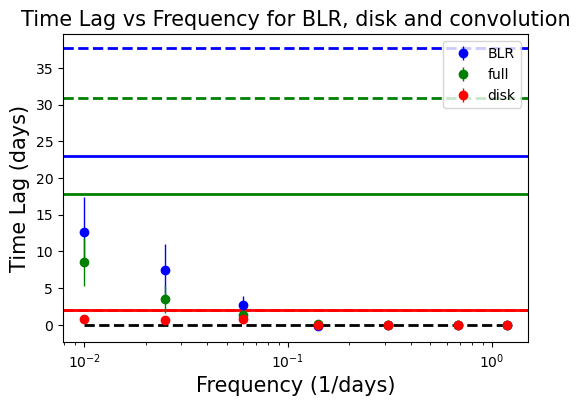

In [25]:


# Plotting
plt.figure(figsize=(6, 4))
plt.hlines(0, log_rb_cs_BLR.freq[0], log_rb_cs_BLR.freq[-1], color='black', linestyle='dashed', lw=2)
plt.errorbar(log_rb_cs_BLR.freq, freq_lags_BLR, yerr=freq_lags_err_BLR, fmt="o", label='BLR', lw=1, color='b')
plt.errorbar(log_rb_cs_full.freq, freq_lags_full, yerr=freq_lags_err_full, fmt="o", label=f'full', lw=1, color='g')
plt.errorbar(log_rb_cs_disk.freq, freq_lags_disk, yerr=freq_lags_err_disk, fmt="o", label=f'disk', lw=1, color='r')
plt.axhline(tlag_centroid_12, lw=2, color='g', zorder=1)
#plt.errorbar(x=0, y=tlag_centroid_12, yerr=[[centau_uperr_12], [centau_loerr_12]], color='red', fmt='o', label='Error Bar (1 and 2)')
plt.axhline(tlag_centroid_13, lw=2, color='blue', zorder=1)
#plt.errorbar(x=0, y=tlag_centroid_13, yerr=[[centau_uperr_13], [centau_loerr_13]], color='blue', fmt='o', label='Error Bar (1 and 3)')
plt.axhline(tlag_centroid_14,  lw=2, color='r', zorder=1)
#plt.errorbar(x=0, y=tlag_centroid_14, yerr=[[centau_uperr_14], [centau_loerr_14]], color='green', fmt='o', label='Error Bar (1 and 4)')
plt.axhline(mean_lag_full, linestyle='--', lw=2,  color='g', zorder=1)
plt.axhline(mean_lag_BLR, linestyle='--', lw=2, color='b', zorder=1)
plt.axhline(mean_lag_Disk, linestyle='--', lw=2, color='r', zorder=1)
plt.xscale('log')
plt.xlabel('Frequency (1/days)',fontsize=15)
plt.ylabel('Time Lag (days)',fontsize=15)

plt.title('Time Lag vs Frequency for BLR, disk and convolution',fontsize=15)
legend = plt.legend(loc='upper right')
plt.setp(legend.get_texts(), zorder=10) 


plt.show()